In [1]:
# demo de-noising using fhmm
# this was attempt 1, all is working but need to streamline so that
# it's simpler to run lots of tests

import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/models', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import librosa
import torchaudio
import numpy as np
import config
import os.path
import math
import os
import pathlib
import random
import torch
import utils
import warnings
import my_torch.torchio as tio
import torchaudio.functional as F
import torchaudio.transforms as T

In [144]:
from whale.setup import get_data, constants, annotations
import importlib
importlib.reload(constants)

importlib.reload(get_data)
from final import useful
importlib.reload(useful)

HUMPBACK = 'humpback'
BOWHEAD = 'bowhead'
NOISE = 'noise'

# constants for fe and what not
fs = 4000
nfft = 256

signal_types = [HUMPBACK, BOWHEAD, NOISE]

signal_types_labels = {
    HUMPBACK: 0,
    BOWHEAD: 1,
    NOISE: 2
}

get_data_dict = {
    HUMPBACK: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.SWOOPS_LABELS_A, fs, useful.file_to_audio)],
    BOWHEAD: [get_data.GetDataSimple(constants.BOWHEAD_WAV_B,constants.BOWHEAD_LABELS_B, fs, useful.file_to_audio)],
    NOISE: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.HUMPBACK_LABEL_A_NOISE, fs, useful.file_to_audio),
            get_data.GetDataSimple(constants.BOWHEAD_WAV_B,constants.BOWHEAD_LABELS_B_NOISE, fs, useful.file_to_audio)]
}

samples, labels = useful.get_samples(get_data_dict, signal_types, signal_types_labels)

__collected samples__
humpback :  18
bowhead :  21
noise :  33


In [145]:
# separate using cross-validation
import final.cross_validation as cv
from final.cross_validation import *
import importlib
importlib.reload(cv)

n_folds = 2
cv_output = cv.split_data_for_cross_validation(samples, labels, n_folds, test_ratio=0.2)

In [146]:
cv_index = 0    # select train and test for this iteration
importlib.reload(useful)
train = useful.SampleHolder(cv_output[TRAIN_DATA][cv_index], cv_output[TRAIN_LABEL][cv_index])
val = useful.SampleHolder(cv_output[VAL_DATA][cv_index], cv_output[VAL_LABEL][cv_index])
test = useful.SampleHolder(cv_output[TEST_DATA], cv_output[TEST_LABEL])

In [147]:
# train hmms
from hmmlearn.hmm import GaussianHMM

hmms = {
    HUMPBACK: GaussianHMM(4),
    BOWHEAD: GaussianHMM(5),
    NOISE: GaussianHMM(4)
}

train.features = []
for sample in train.samples:
    train.features.append(useful.get_log_power_feature(sample, nfft))

for key in hmms:
    cur_hmm = hmms[key]
    feat_indicis = train.sample_labels == signal_types_labels[key]
    hmm_features = [item for item, condition in zip(train.features, feat_indicis) if condition]
    cur_hmm.fit(np.concatenate(hmm_features))

In [148]:
# check / update hmms
importlib.reload(useful)
print(useful.find_similar_states_kl(hmms[BOWHEAD], hmms[NOISE]))

[[285.57922767  40.86810508 297.52725236  51.06720676]
 [282.77555632  48.49161137 314.77875597  50.68549792]
 [189.90883391  10.4496793  203.77486535  25.11869637]
 [436.84904979  90.09674862 437.5951087   90.90033653]
 [331.86304349  58.37119491 358.51089134  63.64732197]]


In [149]:
hmm_bowhead_updated = useful.delete_component(hmms[BOWHEAD], 2)
print(useful.find_similar_states_kl(hmm_bowhead_updated, hmms[NOISE]))
hmms[BOWHEAD] = hmm_bowhead_updated

deleting comp 2
[[285.84453284  40.98923112 297.63745027  51.00878673]
 [282.69259631  48.55886329 314.7297018   50.60094654]
 [436.97792682  90.01400125 437.61711691  90.94610803]
 [331.85597573  58.291205   358.56184684  63.60903405]]


In [150]:
# get accuracy measure then decode combine
import sklearn.metrics
import decode_combine as dc
importlib.reload(dc)
combined_model = dc.DecodeCombineGaussian([hmm for hmm in hmms.values()])

In [151]:
val.features = []
importlib.reload(useful)
for i in range(len(val.samples)):
    feature = useful.get_log_power_feature(val.samples[i], nfft)
    val.features.append(feature)
val.update_feature_labels()

In [152]:
_, val_pred, val_log_prob = combined_model.decode_hmmlearn(np.concatenate(val.features))

decoding using hmmlearn


In [153]:
# pretty good for bad annotations
accuracy = useful.perf_measure(np.concatenate(val.feature_labels), val_pred)

In [154]:
test.features = []
for i in range(len(test.samples)):
    feature = useful.get_log_power_feature(test.samples[i], nfft)
    test.features.append(feature)
test.update_feature_labels()

In [155]:
test_features_concat = np.concatenate(test.features)
_, test_pred, test_log_prob = combined_model.decode_hmmlearn(test_features_concat)

decoding using hmmlearn


In [162]:
test_features_concat_subset = test_features_concat[:1000,:]
test_pred_subset = test_pred[:1000]

In [178]:
def smooth_labels(labels, window_size=50, step_size=10):

    smoothy_labels = labels.copy()
    arg_max = []
    arg_max_index = []

    for start in range(0, len(labels) - window_size + 1, step_size):
        end = start + window_size
        window = labels[start:end]

        unique_elements, counts = np.unique(window, return_counts=True)
        max_count_index = np.argmax(counts)
        dominant_label = unique_elements[max_count_index]
        arg_max.append(dominant_label)
        arg_max_index.append(start)

    changes = []
    changes_index = []
    for i in range(1, len(labels)):
        if labels[i] != labels[i - 1]:
            changes.append(labels[i])
            changes_index.append(i)

    fwd = changes[2]
    curr = changes[1]
    prev = changes[0]
    for i in range(2, len(changes)):
        fwd = changes[i]
        curr = changes[i-1]
        prev = changes[i-2]
        index_curr = changes_index[i-1]
        index_fwd = changes_index[i]
        diff = index_fwd - index_curr
        if diff < 40:
            print('possible quick switch')
            arg_max_index_cur = np.argmin(np.abs(np.array(arg_max_index) - index_curr))
            arg_max_index_fwd = np.argmin(np.abs(np.array(arg_max_index) - index_fwd))
            if(
                arg_max[arg_max_index_cur] == arg_max[arg_max_index_fwd]
            ):
                print('quick switch')
                smoothy_labels[index_curr: index_fwd] = np.ones(diff) * fwd
            # if diff is small and average is index fwd then

            # print(diff)
    return smoothy_labels

smoothed_labels = smooth_labels(test_pred_subset)
# print("Original Labels:", labels)
# print("Smoothed Labels:", smooth_labels(labels))

possible quick switch
quick switch
possible quick switch
quick switch
possible quick switch


KeyboardInterrupt: 

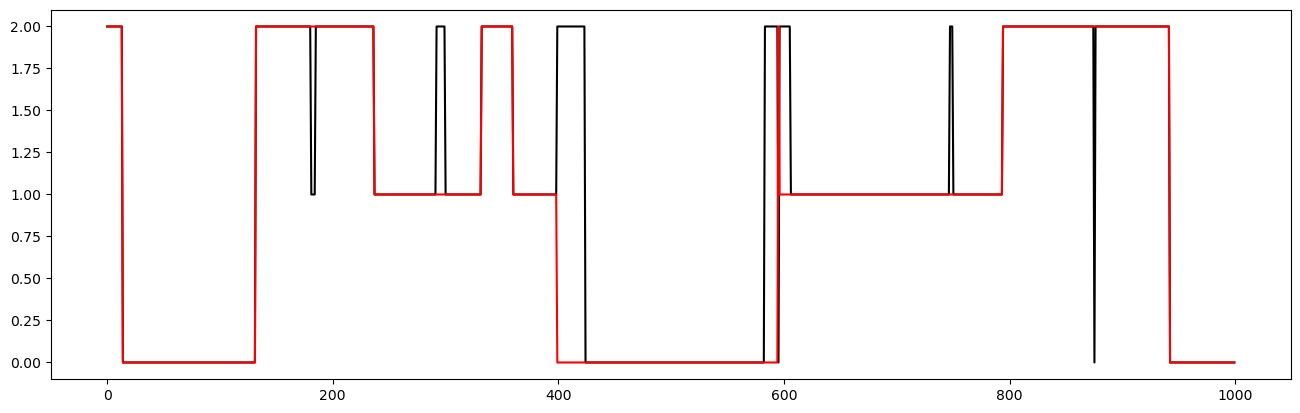

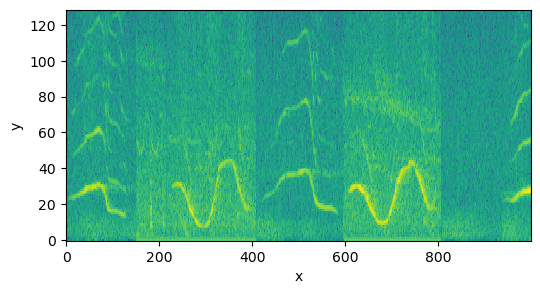

In [176]:
import matplotlib.pyplot as plt
plt.plot(test_pred_subset, c='black')
plt.plot(smoothed_labels, c='red')
useful.vis_helper(test_features_concat_subset)

In [177]:
label_mapping = {
    0: 'H',
    1: 'B',
    2: 'N',
}

def find_label_changes(labels, dict):
    changes = []
    for i in range(1, len(labels)):
        if labels[i] != labels[i - 1]:
            changes.append((i, dict[labels[i]]))
    return changes

label_changes = find_label_changes(smoothed_labels, label_mapping)

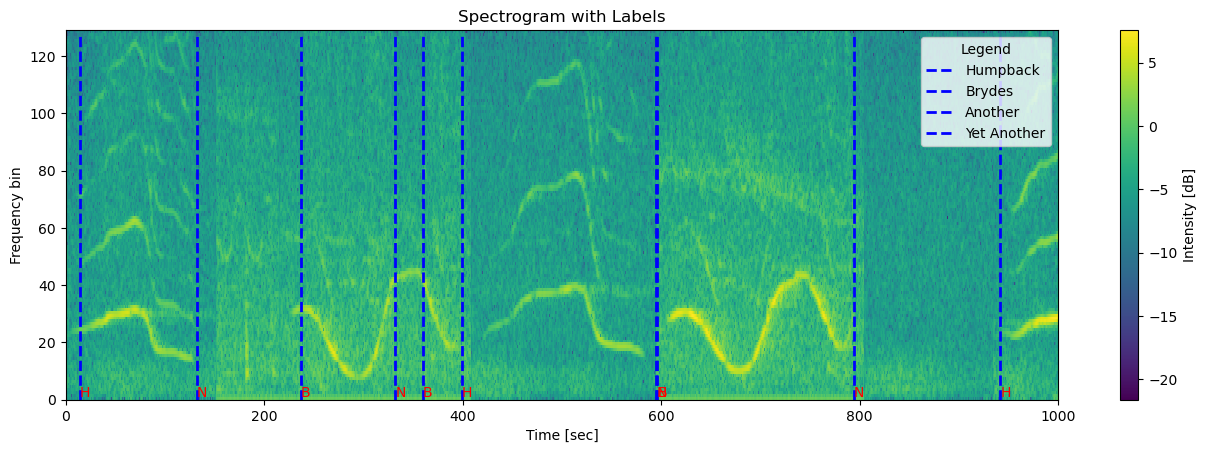

In [173]:

times = np.arange(test_features_concat_subset.shape[0])
frequencies = np.arange(test_features_concat_subset.shape[1])

# Create a spectrogram
labels_Alph = ['A', 'B', 'C', 'D']
label_names = {'A': 'Humpback', 'B': 'Brydes', 'C': 'Another', 'D': 'Yet Another'}
label_indices = [10, 30, 50, 70]

plt.pcolormesh(test_features_concat_subset.T)
plt.ylabel('Frequency bin')
plt.xlabel('Time [sec]')

for index, label in label_changes:
    plt.text(times[index], frequencies[0], label, color='red', fontsize=10, verticalalignment='bottom')
    plt.vlines(times[index], ymin=frequencies.min(), ymax=frequencies.max(), color='blue', linestyles='dashed', linewidth=2)

# plt.vlines(times[label_indices], ymin=frequencies.min(), ymax=frequencies.max(), color='blue', linestyles='dashed', linewidth=2)

legend_labels = [label_names[label] for label in labels_Alph]
plt.legend(legend_labels, loc='upper right', title='Legend')
plt.colorbar(label='Intensity [dB]')
plt.title('Spectrogram with Labels')
plt.show()